In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

import numpy as np
import pandas as pd
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import *


In [2]:
IGNORE_LIST = ('saycam_split_text_test.csv', 'saycam_nan_test.csv')


def load_and_join_dataframes(folder, ext='.csv', ignore_list=IGNORE_LIST) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df


def parse_model_name(df):
    new_series_values = defaultdict(list)

    for name in df.model_name:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def parse_above_below_condition(df):
    above_below_types = []

    for _, (relation, two_refs, adjacent_refs) in \
        df.loc[:, ['relation', 'two_reference_objects', 'adjacent_reference_objects']].iterrows():
        a_b_type = None

        if relation == 'above_below':
            if not two_refs:
                a_b_type = 'one_reference'

            elif adjacent_refs:
                a_b_type = 'adjacent_references'

            else:
                a_b_type = 'gapped_references'

        above_below_types.append(a_b_type)

    return df.assign(above_below_type=above_below_types)

    
combined_df = load_and_join_dataframes('../embedding_outputs')
combined_df.drop(columns=[combined_df.columns[0]], inplace=True)
combined_df = parse_model_name(combined_df)
combined_df = parse_above_below_condition(combined_df)
combined_df.rotate_angle.fillna(0, inplace=True)
combined_df.rotate_angle = combined_df.rotate_angle.astype(int)


In [3]:
REORDERED_COLUMNS = [
    'model', 'condition', 'relation', 'training', 'flip', 'dino', 'rotate_angle',
    'acc_mean', 'acc_std', 'acc_sem', 
    'above_below_type', 'two_reference_objects', 'adjacent_reference_objects', 'n_target_types',
    'transpose_stimuli', 'n_habituation_stimuli',  
    'seed', 'n_examples', 'extra_diagonal_margin', 
]
combined_df = combined_df.reindex(columns=REORDERED_COLUMNS)

In [4]:
combined_df.head(n=10)

,model,condition,relation,training,flip,dino,rotate_angle,acc_mean,acc_std,acc_sem,above_below_type,two_reference_objects,adjacent_reference_objects,n_target_types,transpose_stimuli,n_habituation_stimuli,seed,n_examples,extra_diagonal_margin
0,mobilenet,different_shapes,above_below,random,None,None,0,0.507812,0.499939,0.015623,one_reference,0,0,1,NaN,1,34,1024,0
1,mobilenet,split_text,above_below,random,None,None,0,0.503906,0.499985,0.015625,one_reference,0,0,1,NaN,1,34,1024,0
2,mobilenet,random_color,above_below,random,None,None,0,0.515625,0.499756,0.015617,one_reference,0,0,1,NaN,1,34,1024,0
3,resnext,different_shapes,above_below,random,None,None,0,0.641602,0.479530,0.014985,one_reference,0,0,1,NaN,1,34,1024,0
4,resnext,split_text,above_below,random,None,None,0,0.605469,0.488750,0.015273,one_reference,0,0,1,NaN,1,34,1024,0
5,resnext,random_color,above_below,random,None,None,0,0.586914,0.492388,0.015387,one_reference,0,0,1,NaN,1,34,1024,0
6,mobilenet,different_shapes,above_below,random,None,None,30,0.514648,0.499785,0.015618,one_reference,0,0,1,NaN,1,34,1024,0
7,mobilenet,split_text,above_below,random,None,None,30,0.500977,0.499999,0.015625,one_reference,0,0,1,NaN,1,34,1024,0
8,mobilenet,random_color,above_below,random,None,None,30,0.506836,0.499953,0.015624,one_reference,0,0,1,NaN,1,34,1024,0
9,resnext,different_shapes,above_below,random,None,None,30,0.507812,0.499939,0.015623,one_reference,0,0,1,NaN,1,34,1024,0


In [5]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.List[str],
    mean: pd.core.groupby.SeriesGroupBy,
    std: pd.core.groupby.SeriesGroupBy,
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
):

    key = tuple(key)
    m = mean.loc[key]
    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    return x + bar_width 
    # TODO: above bar texts would go here, if they exist


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: pd.core.groupby.SeriesGroupBy,
    std: pd.core.groupby.SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        ax.hlines(0.5, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    ax.set_ylabel(ylabel, **text_kwargs)


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None):

    patches = []

    if legend_ncol is None:
        ncol = 1

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=ncol, fontsize=text_kwargs['fontsize'] - 4)
    

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_std: bool = True,
    sem: bool = True,
    orders_by_field: typing.Dict[str, typing.Sequence[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, 
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Tuple[float, float] = None,
    layout: typing.Tuple[int, int] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    mean = grouped_df.acc_mean.mean()
    if sem:
        std = grouped_df.acc_sem.mean()
    else:
        std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        plot_single_panel(ax, mean, std, 
            plot_std, orders_by_field, plot_style_by_field,
            group_bars_by, color_bars_by, hatch_bars_by,
            bar_width, bar_group_spacing, add_chance_hline,
            global_bar_kwargs, text_kwargs, 
            ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
            text_kwargs, legend_loc, legend_ncol)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles)

    else:
        n_rows, n_cols = layout
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        for i, panel_value in enumerate(orders_by_field[panel_by]):
            panel_ax = ax[i]
            plot_single_panel(panel_ax, mean[panel_value], std[panel_value], 
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, add_chance_hline,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel if i % n_rows == 0 else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol)

            title = f'{panel_by} = {panel_value}'
            if panel_titles is not None:
                title = panel_titles[i]
                
            panel_ax.set_title(title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

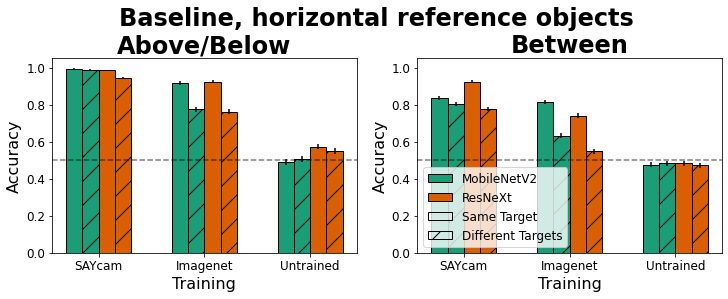

In [6]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'],
        flip=None, dino=None, rotate_angle=0),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    sup_title='Baseline, horizontal reference objects',
    legend_ax_index=1,
    legend_loc='lower left',
    save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

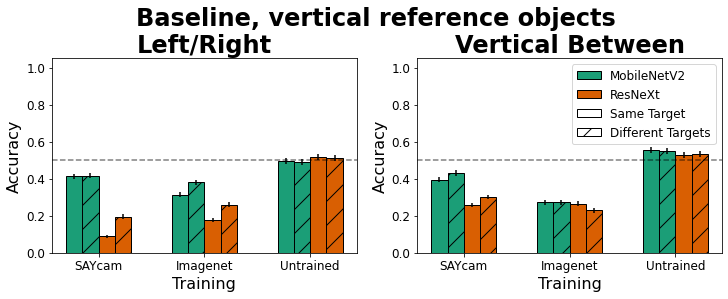

In [7]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], 
        flip=None, dino=None, rotate_angle=90),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Left/Right', 'Vertical Between'],
    sup_title='Baseline, vertical reference objects',
    legend_ax_index=1,
    save_path='baseline_vertical_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

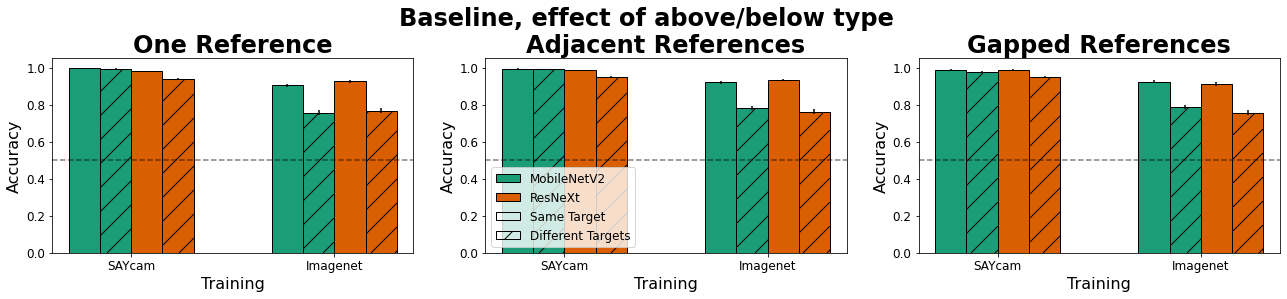

In [19]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], 
        relation='above_below', flip=None, dino=None, rotate_angle=0),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='above_below_type',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (22, 4),
    layout = (1, 3),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['One Reference', 'Adjacent References', 'Gapped References'],
    sup_title='Baseline, effect of above/below type',
    legend_ax_index=1,
    legend_loc='lower left',
    save_path='baseline_above_below_types.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

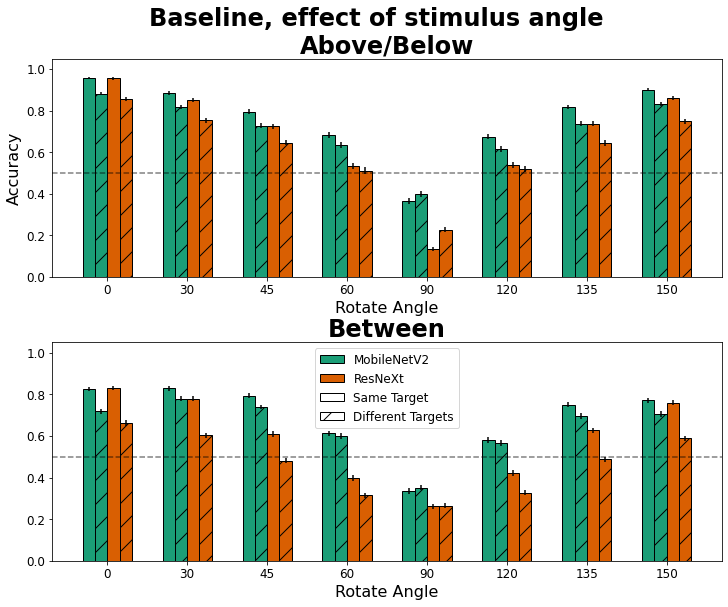

In [9]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['ImageNet', 'saycam(S)'], 
        flip=None, dino=None),
    group_bars_by='rotate_angle', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Baseline, effect of stimulus angle',
    subplot_adjust_params=dict(top=0.9, hspace=0.3),
    save_path='baseline_stimulus_angle.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

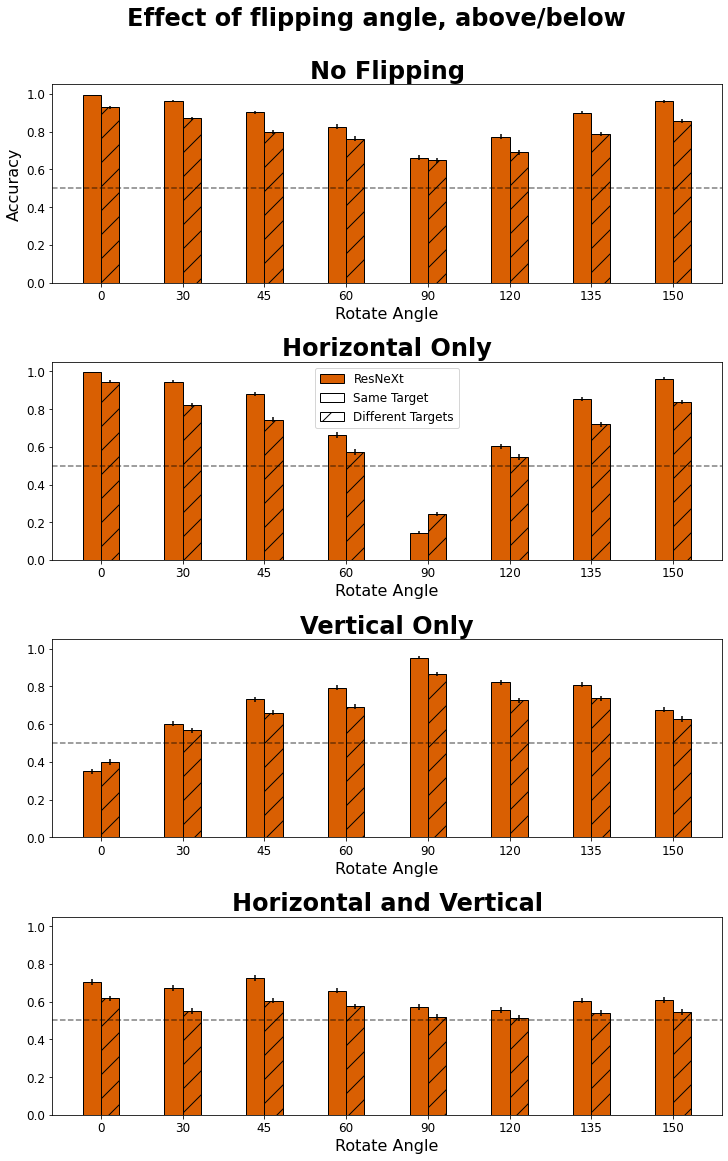

In [10]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, relation='above_below'),
    group_bars_by='rotate_angle', 
    color_bars_by='model', 
    panel_by='flip',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['No Flipping', 'Horizontal Only', 'Vertical Only', 'Horizontal and Vertical'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Effect of flipping angle, above/below',
    subplot_adjust_params=dict(top=0.92, hspace=0.4),
    save_path='stimulus_angle_flipping_above_below.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

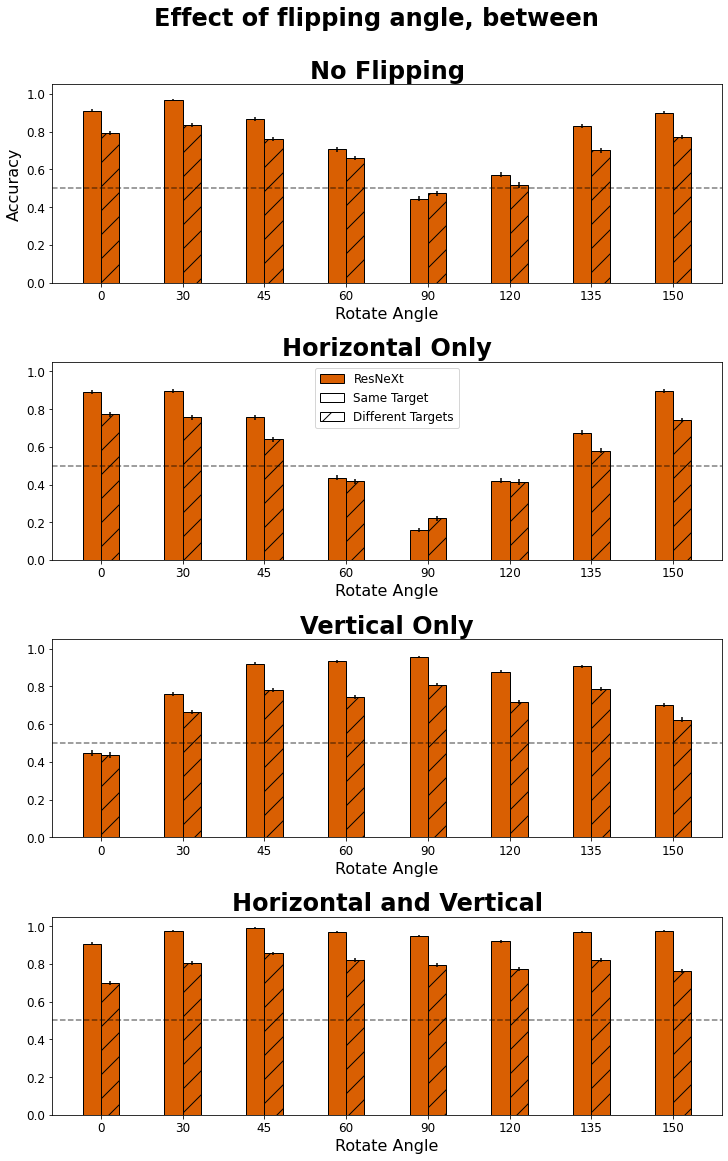

In [11]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None, relation='between'),
    group_bars_by='rotate_angle', 
    color_bars_by='model', 
    panel_by='flip',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 18),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['No Flipping', 'Horizontal Only', 'Vertical Only', 'Horizontal and Vertical'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Effect of flipping angle, between',
    subplot_adjust_params=dict(top=0.92, hspace=0.4),
    save_path='stimulus_angle_flipping_between.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

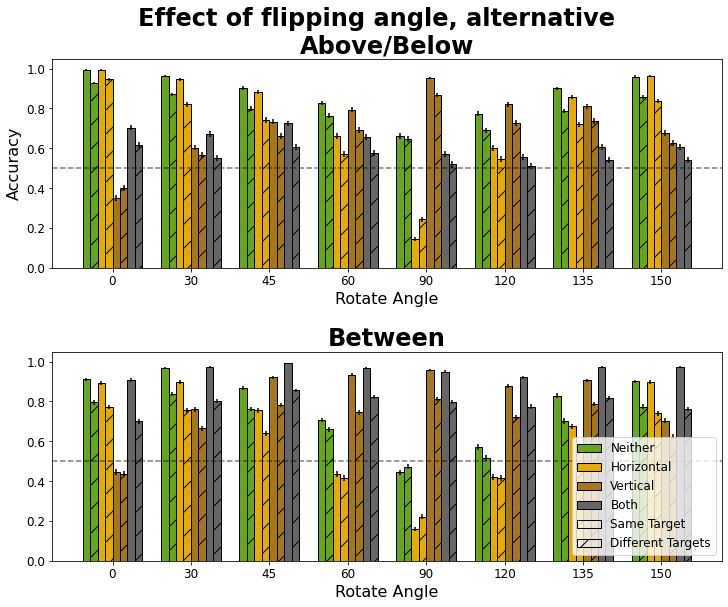

In [12]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip', 
        dino=None),
    group_bars_by='rotate_angle', 
    color_bars_by='flip', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='lower right',
    sup_title='Effect of flipping angle, alternative',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='stimulus_angle_flipping_coimbined.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

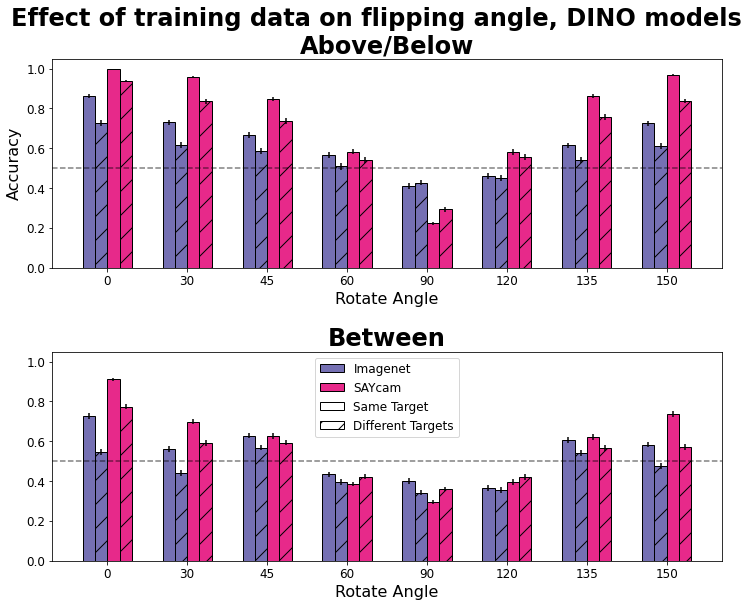

In [13]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO', 
        flip=None),
    group_bars_by='rotate_angle', 
    color_bars_by='dino', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot style arguments
    figsize = (12, 9),
    layout = (2, 1),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    legend_ax_index=1,
    legend_loc='upper center',
    sup_title='Effect of training data on flipping angle, DINO models',
    subplot_adjust_params=dict(top=0.9, hspace=0.4),
    save_path='dino_models_stimulus_angle.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

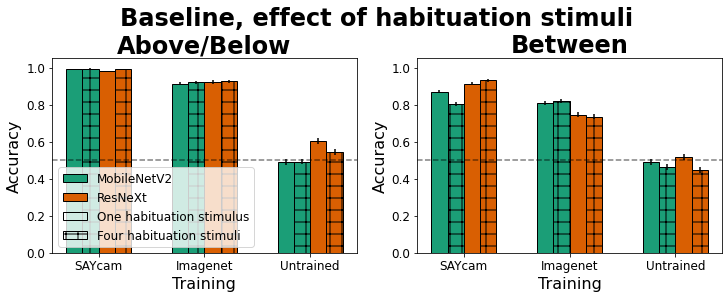

In [18]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], 
        flip=None, dino=None, rotate_angle=0, n_target_types=1),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (12, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    sup_title='Baseline, effect of habituation stimuli',
    legend_ax_index=0,
    legend_loc='lower left',
    save_path='number_of_habituation_stimuli.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

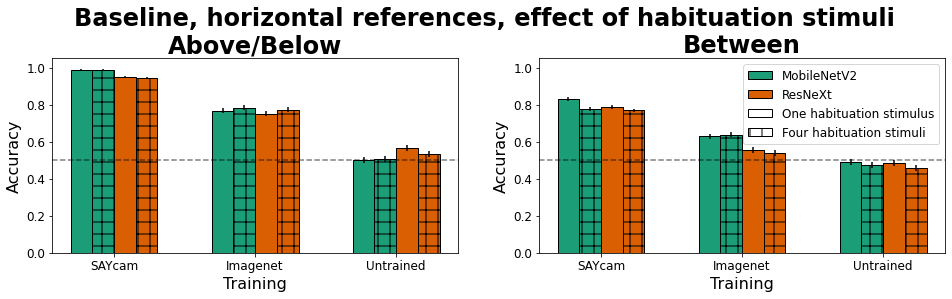

In [17]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], 
        flip=None, dino=None, rotate_angle=0, n_target_types=2),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_habituation_stimuli',
    # plot style arguments
    figsize = (16, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    sup_title='Baseline, horizontal references, effect of habituation stimuli',
    legend_ax_index=1
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [16]:
combined_df.head()

,model,condition,relation,training,flip,dino,rotate_angle,acc_mean,acc_std,acc_sem,above_below_type,two_reference_objects,adjacent_reference_objects,n_target_types,transpose_stimuli,n_habituation_stimuli,seed,n_examples,extra_diagonal_margin
0,mobilenet,different_shapes,above_below,random,None,None,0,0.507812,0.499939,0.015623,one_reference,0,0,1,NaN,1,34,1024,0
1,mobilenet,split_text,above_below,random,None,None,0,0.503906,0.499985,0.015625,one_reference,0,0,1,NaN,1,34,1024,0
2,mobilenet,random_color,above_below,random,None,None,0,0.515625,0.499756,0.015617,one_reference,0,0,1,NaN,1,34,1024,0
3,resnext,different_shapes,above_below,random,None,None,0,0.641602,0.479530,0.014985,one_reference,0,0,1,NaN,1,34,1024,0
4,resnext,split_text,above_below,random,None,None,0,0.605469,0.488750,0.015273,one_reference,0,0,1,NaN,1,34,1024,0
